In [1]:
# this notebook shows how a small epsilon size can cause the toroid mirror to produce very different results
# epsilon is 1e-08
# two simulations are run, with only a small difference in the distance leading up to the toroid mirror

%matplotlib inline
import matplotlib.pyplot as plt
from Shadow.ShadowPreprocessorsXraylib import prerefl, pre_mlayer, bragg
from pykern import pkjson
from pykern.pkcollections import PKDict
from pykern.pkdebug import pkdc, pkdp
from sirepo.template import transfer_mat_bl
from srxraylib.sources import srfunc
import Shadow
import math
import numpy
import re

In [2]:
source = Shadow.Source()
beam = Shadow.Beam()
source.NPOINT = 10000
source.ISTAR1 = 567656

source.SIGMAX = 0.012526741356
source.SIGMAZ = 0.001341640786
source.EPSI_X = 5.500000000000001e-08
source.EPSI_Z = 8e-10
source.BENER = 3.0
source.EPSI_DX = 0.0
source.EPSI_DZ = 0.0
source.F_POL = 3
source.HDIV1 = 0.0005
source.HDIV2 = 0.0005
source.VDIV1 = 1.0
source.VDIV2 = 1.0
source.F_PHOT = 0
source.FSOURCE_DEPTH = 4
source.F_COLOR = 3
source.R_MAGNET = 25.0173071398614
source.PH1 = 2500.0
source.PH2 = 2500.001
source.FDISTR = 4
source.R_ALADDIN = source.R_MAGNET * 100
beam.genSource(source)
rays = beam.rays

def rays_sigma(rays, idx):
    return numpy.sqrt(numpy.mean(rays[:, idx] ** 2))

sigmax = rays_sigma(rays, 0)
sigdix = rays_sigma(rays, 3)
sigmaz = rays_sigma(rays, 2)
sigdiz = rays_sigma(rays, 5)

beam_stats = []
epsilon = 1e-08
beam = None

sigma_mat = numpy.matrix([
    [sigmax ** 2, 0, 0, 0],
    [0, sigdix ** 2, 0, 0],
    [0, 0, sigmaz ** 2, 0],
    [0, 0, 0, sigdiz ** 2],
])
alpha = 0


 Generated          500  rays out of        10000
                   1000
                   1500
                   2000
                   2500
                   3000
                   3500
                   4000
                   4500
                   5000
                   5500
                   6000
                   6500
                   7000
                   7500
                   8000
                   8500
                   9000
                   9500
                  10000
 Exit from SOURCE


In [3]:
def assert_no_lost_rays(beam):
    lost = []
    LOST_RAY_FLAG = 9
    for i in range(len(beam.rays)):
        if beam.rays[i][LOST_RAY_FLAG] != 1:
            lost.append(i)
    if len(lost):
        raise AssertionError(
            'Lost tracking particle(s) # {}'.format(
                ', '.join(str(v) for v in lost)),
        )

def calculate_stats(pos, oe):
    global alpha
    global sigma_mat
    global epsilon
    Tmat, x_prop_cen, xp_prop_cen, z_prop_cen, zp_prop_cen = transfer_mat_bl.tmat_calc(beam.duplicate(), epsilon)
    res = Tmat * sigma_mat * numpy.transpose(Tmat)
    pos += (oe.T_SOURCE if oe else 0)
    if oe:
        # oe.ALPHA is in radians after traceOE()
        alpha = int(alpha + 180 / math.pi * oe.ALPHA) % 360
    beam_stats.append(PKDict(
        isRotated=True if alpha == 90 or alpha == 270 else False,
        s=pos * 1e-2,
        x=x_prop_cen,
        xp=xp_prop_cen,
        z=z_prop_cen,
        zp=zp_prop_cen,
        matrix=Tmat.tolist(),
        sigma_mx=res.tolist(),
        sigmax=math.sqrt(res[0, 0]) * 1e-2,
        sigdix=math.sqrt(res[1, 1]),
        sigmaz=math.sqrt(res[2, 2]) * 1e-2,
        sigdiz=math.sqrt(res[3, 3]),
    ))
    return pos

def divide_drift(pos, count, distance, divisions=100):
    if distance < 1e-3:
        return
    for i in range(divisions - 1):
        oe = Shadow.OE()
        oe.DUMMY = 1.0
        oe.set_empty(ALPHA=0)
        oe.FWRITE = 3
        oe.T_IMAGE = 0.0
        oe.T_SOURCE = distance / divisions
        beam.traceOE(oe, count)
        count += 1
        pos = calculate_stats(pos, oe)
    return pos

def process_stats():
    def compute_angx(x, z, xz, scale=1):
        x = numpy.array(x)
        z = numpy.array(z)
        xz = numpy.array(xz)
        return ((1/2) * numpy.arctan(2 * scale * xz / (x ** 2 - z ** 2))).tolist()

    def rotated_values(stats, field):
        if field == 'sigmaxz':
            return [-v.sigma_mx[0][2] if v.isRotated else v.sigma_mx[0][2] for v in stats]
        if field == 'sigmaxpzp':
            return [-v.sigma_mx[1][3] if v.isRotated else v.sigma_mx[1][3] for v in stats]
        if re.search('z', field):
            f = re.sub('z', 'x', field)
        else:
            f = re.sub('x', 'z', field)
        return [v[f] if v.isRotated else v[field] for v in stats]

    res = PKDict(
        s=[v.s for v in beam_stats],
    )
    for f in ('sigmax', 'sigdix', 'sigmaz', 'sigdiz', 'sigmaxz', 'sigmaxpzp', 'x', 'xp', 'z', 'zp'):
        res[f] = rotated_values(beam_stats, f)
    res.angxz = compute_angx(res.sigmax, res.sigmaz, res.sigmaxz, scale=1e-4)
    res.angxpzp = compute_angx(res.sigdix, res.sigdiz, res.sigmaxpzp)
    return res


In [4]:
def run_shadow(toroid_source_distance):
    global beam_stats
    global beam
    beam = transfer_mat_bl.create_mat_rays(epsilon, 2500.0)
    beam_stats = []
    pos = calculate_stats(0, None)

    pos = divide_drift(pos, 1, 1657.0)

    # toroid mirror
    oe = Shadow.OE()
    oe.DUMMY = 1.0
    oe.FMIRR = 3
    oe.ALPHA = 0
    oe.FHIT_C = 0
    oe.F_EXT = 1
    oe.F_TORUS = 0
    oe.R_MAJ = 2450000.0
    oe.R_MIN = 18.6
    oe.T_INCIDENCE = 89.59892954340842
    oe.T_REFLECTION = 89.59892954340842
    oe.FWRITE = 3
    oe.T_IMAGE = 0.0
    oe.T_SOURCE = toroid_source_distance
    beam.traceOE(oe, 100)
    pos = calculate_stats(pos, oe)

    pos = divide_drift(pos, 101, 3057.2000000000007)

    oe = Shadow.OE()
    oe.DUMMY = 1.0
    oe.set_empty()
    oe.FWRITE = 3
    oe.T_IMAGE = 0.0
    oe.T_SOURCE = 30.572000000000006
    beam.traceOE(oe, 200)
    pos = calculate_stats(pos, oe)

    assert_no_lost_rays(beam)
    return process_stats()

In [5]:
stats = run_shadow(16.57)

 Exit from SOURCE
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from I

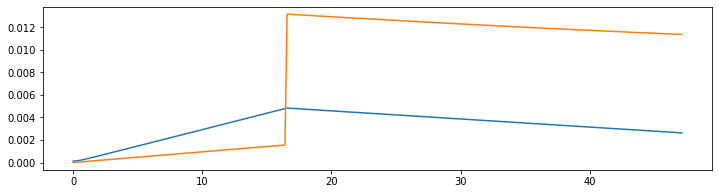

In [6]:
# this shows the beamline with no apertures applied
plt.figure(figsize=(12,3))
plt.plot(stats.s, stats.sigmax)
plt.plot(stats.s, stats.sigmaz)
plt.show()

In [7]:
stats = run_shadow(16.405940594059405)

 Exit from SOURCE
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from I

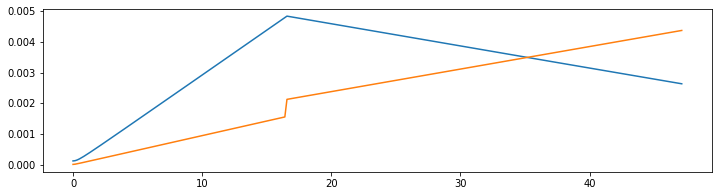

In [8]:
# this shows the beamline with no apertures applied
plt.figure(figsize=(12,3))
plt.plot(stats.s, stats.sigmax)
plt.plot(stats.s, stats.sigmaz)
plt.show()